In [1]:
import nk_landscape
import gaussian_markov_random_field
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import random
import sequence_evolution
import graph_ruggedness_de
import graph_utils
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import spearmanr
from timestep_opt import fit_t_bayesian_laplace
from math import sqrt, pi, exp

### Figure 2.
The purpose of Figure 2 is to present an overview of the simulation systems and the performance of the GMRF in quantifying ruggedness, when ruggedness is a controlable parameter, between fitness landscpaes. Figure 2 uses both nk landscapes from `nk_landscape` and elementary landscapes from `graph_ruggedness_de`.

The below cell uses `sequence_evolution.sample_sequences` to simulate an evolutionary process of random phylogenetic trees, using realistic evolutionary parameters. The fitness over these sequences are computed using the `graph_ruggedness_de.compute_elementary_landscape`, which uses the `n`th Laplacian eigenvector as the signal over the graph. 

In [45]:
#Laplacian eigenvector indices
n0 = 3
n1 = 50

sample_size = 1
for _ in tqdm(enumerate(range(sample_size))):
    try:

        num_nodes = 200
        mean_branch_length = np.random.uniform(0.01, 0.5)
        std_dev_branch_length = np.random.uniform(0.001, 0.1)
        alpha = np.random.uniform(0.1, 0.5)
        model = random.choice(('WAG', 'LG'))
        rate_categoies = 4
        sequence_length = int(np.random.uniform(100, 600))

        sample_info = {
            'num_nodes' : num_nodes,
            'mean_branch_length' : mean_branch_length,
            'std_dev_branch_length' : std_dev_branch_length,
            'alpha' : alpha,
            'model' : model,
            'sequence_length' : sequence_length
        }

        seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                        mean_branch_length=mean_branch_length,
                                                        std_dev_branch_length=std_dev_branch_length,
                                                        alpha=alpha,
                                                        model=model,
                                                        rate_categories=rate_categoies,
                                                        sequence_length=sequence_length
                                                        )
        seq_ls = list(seq_dict.values())
        values = [0]*len(seq_ls)
        G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                            values=values)
    
    except:
        continue

#Define the signals over G0 and G1 as the n0th and n1st Laplacian eignevectors.
G0 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=n0)
G1 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=n1)

0it [00:00, ?it/s]

Computing all vs. all OHE distance matrix.


1it [00:02,  2.58s/it]

Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.


The below cell computes the maximum a posteriori t value, `t_map`, as well as the Guassian approximation of the posterior using the Laplace approximation from `timestep_opt.fit_t_bayesian_laplace`.

In [46]:
t_map, ci_lower, ci_upper, logpost_map, var_approx = fit_t_bayesian_laplace(G=G0)

/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:110: RuntimeWarning: divide by zero encountered in divide
  inv_h_i_scaled = 1 / h_i_scaled
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:110: RuntimeWarning: overflow encountered in divide
  inv_h_i_scaled = 1 / h_i_scaled
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:116: RuntimeWarning: divide by zero encountered in log
  log_det = np.sum(np.log(h_i_scaled))
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:119: RuntimeWarning: invalid value encountered in scalar subtract
  log_likelihood = -0.5 * quadratic_form - 0.5 * log_det - (n / 2) * np.log(2 * np.pi)


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_81944/924236662.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='Signal')


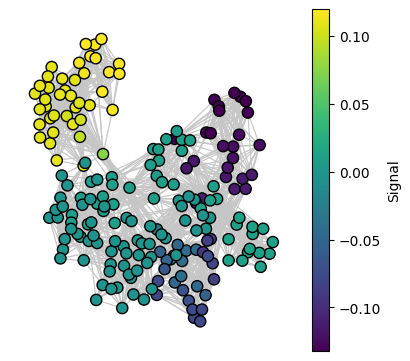

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_81944/924236662.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='Signal')


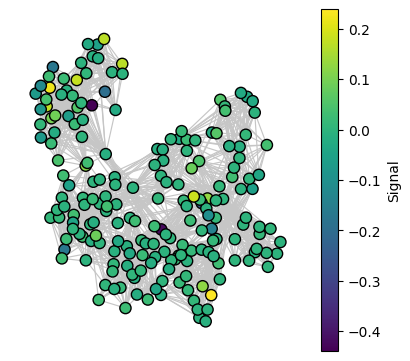

In [47]:
pos = nx.spring_layout(G, k=0.5)
signal0 = np.array([node[1]['value'] for node in G0.nodes(data=True)])
signal1 = np.array([node[1]['value'] for node in G1.nodes(data=True)])

fig, ax = plt.subplots(figsize=(4, 3.5), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal0, ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='Signal')

plt.savefig('../figures/figure_2/panel_a.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3.5), constrained_layout=True)

norm1, cmap1 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal1, ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm.set_array([]) 
fig.colorbar(sm, label='Signal')

plt.savefig('../figures/figure_2/panel_b.pdf', bbox_inches='tight')
plt.show()


The below cell creates (and plots) a realization of the GMRF using `gaussian_markov_random_field.generate_sample_H0`, as well as the marginal variance (the diagonal elements of the covariance matrix) using `gaussian_markov_random_field.compute_variance_H0` as the signal over the ndoes of the network graph. 

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_81944/1154589852.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='Signal')


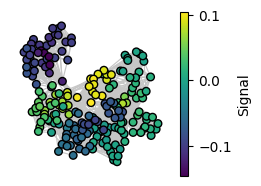

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_81944/1154589852.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='Variance')


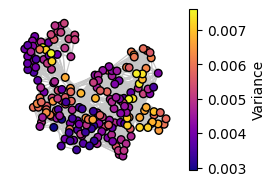

In [48]:
#Fit variance
sigma_squared = np.var(signal0, ddof=1)
#Timestep = 10
t0 = 10

#Generate sample under heat diffusion model and Gaussian Markov random field.
h0_sample = gaussian_markov_random_field.generate_sample_H0(G=G,
                                                            sigma_squared=sigma_squared,
                                                            t=t0)

fig, ax = plt.subplots(figsize=(2.5, 1.75), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=h0_sample, ax=ax, nodesize=30)
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='Signal')

plt.savefig('../figures/figure_2/panel_c.pdf', bbox_inches='tight')
plt.show()


variances_H0, Sigma_H0 = gaussian_markov_random_field.compute_variances_H0(sigma_squared=sigma_squared,
                                                                           t=t_map,
                                                                           G=G)


fig, ax = plt.subplots(figsize=(2.65, 1.75), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=variances_H0, ax=ax, nodesize=30, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=cmap0, norm=norm0)
sm.set_array([]) 
fig.colorbar(sm, label='Variance')

plt.savefig('../figures/figure_2/panel_d.pdf', bbox_inches='tight')
plt.show()

The cell below plots the covariance matrix of the GMRF parameterised with `t_map` for an elementary landscape. 

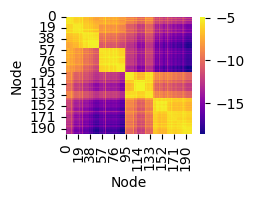

In [49]:
fig = plt.subplots(figsize=(2.6, 2.1))
sns.heatmap(np.log(Sigma_H0), cmap='plasma')
plt.xlabel('Node')
plt.ylabel('Node')
plt.tight_layout()
plt.savefig('../figures/figure_2/panel_e_covariance_matrix.pdf')
plt.show()


The below cell computes the posterior distributions for the t parameter using `fit_t_bayesian_laplace`, for `G0` and `G1`.

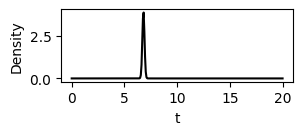

In [5]:
t_min = 0.01,
t_max = 20

t_map, ci_lower, ci_upper, logpost_map, var_approx = fit_t_bayesian_laplace(G=G0, t_min=0.01, t_max=20.0)
std_approx = np.sqrt(var_approx)

num_points = 300
t_vals = np.linspace(t_min, t_max, num_points)

def normal_pdf(t, mean, sigma):
    return 1.0/(sigma * np.sqrt(2*pi)) * np.exp(-0.5*((t - mean)/sigma)**2)

poster_laplace = normal_pdf(t_vals, t_map, std_approx)


plt.figure(figsize=(3,1.5))
plt.plot(t_vals, poster_laplace, 'black')
#plt.axvline(t_map, color='k', linestyle='--', label=f"t_map={t_map:.2f}")
plt.xlabel('t')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_2/panel_e.pdf')
plt.show()


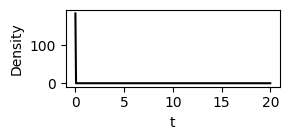

In [6]:
t_min = 0.01,
t_max = 20

t_map, ci_lower, ci_upper, logpost_map, var_approx = fit_t_bayesian_laplace(G=G1, t_min=0.01, t_max=20.0)
std_approx = np.sqrt(var_approx)

num_points = 300
t_vals = np.linspace(t_min, t_max, num_points)

def normal_pdf(t, mean, sigma):
    return 1.0/(sigma * np.sqrt(2*pi)) * np.exp(-0.5*((t - mean)/sigma)**2)

poster_laplace = normal_pdf(t_vals, t_map, std_approx)


plt.figure(figsize=(3,1.5))
plt.plot(t_vals, poster_laplace, 'black')
#plt.axvline(t_map, color='k', linestyle='--', label=f"t_map={t_map:.2f}")
plt.xlabel('t')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/figure_2/panel_f.pdf')
plt.show()

## Laplacian Eigenvector landscapes
Landscapes are initialised from a realistic simulation of evolution over a phylogenetic tree. The fitness / signal at each node is assigned according to the `n`th Laplacian eigenvector. As `n` increases, the complexity / frequency of the eigenmode increases and the landscape becomes more rugged. 

The below cell simulates different fitness landscapes with `sequence_evolution.sequence_evolution` and `graph_ruggedness_de.compute_elementary_landscape`, and computes their likelihoods with `timeste_opt.fit_t_bayesian_laplace` at different levels of controlled ruggedness. 

In [ ]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(5):
    #Sample evolutionary parameters.
    num_nodes = 200
    #num_nodes = np.random.randint(200, 1000)
    mean_branch_length = np.random.uniform(0.01, 0.5)
    std_dev_branch_length = np.random.uniform(0.001, 0.1)
    alpha = np.random.uniform(0.1, 0.5)
    model = random.choice(('WAG', 'LG'))
    rate_categoies = 4
    sequence_length = int(np.random.uniform(100, 600))

    sample_info = {
        'num_nodes' : num_nodes,
        'mean_branch_length' : mean_branch_length,
        'std_dev_branch_length' : std_dev_branch_length,
        'alpha' : alpha,
        'model' : model,
        'sequence_length' : sequence_length
    }

    #Perform sequence evolution.
    seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                    mean_branch_length=mean_branch_length,
                                                    std_dev_branch_length=std_dev_branch_length,
                                                    alpha=alpha,
                                                    model=model,
                                                    rate_categories=rate_categoies,
                                                    sequence_length=sequence_length
                                                    )
    #Construct graph from simulated sequences.

    seq_ls = list(seq_dict.values())
    values = [0]*len(seq_ls)
    G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values)
    de_logprob_dict = {}

    eign_list = list(range(50))
    
    #Iterate through Laplacian eigenvectors.
    for eign in eign_list:
        
        #Assign fitness scores as eigenvectors.
        G_elem = graph_ruggedness_de.compute_elementary_landscape(G=G, n=eign)

        #Compute t parameter.
        t_map, ci_lower, ci_upper, logpost_map, _ = fit_t_bayesian_laplace(G=G_elem, t_max=100, t_min=0.1)
        de_logprob_dict[eign] = t_map

    
    #Store evolutionary parameters.
    rep_sample_info_dict[_] = sample_info

    #Store -log(P) information to dictionary per replicate.
    rep_dict[_] = de_logprob_dict

Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.
Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.
Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.
Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.
Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.


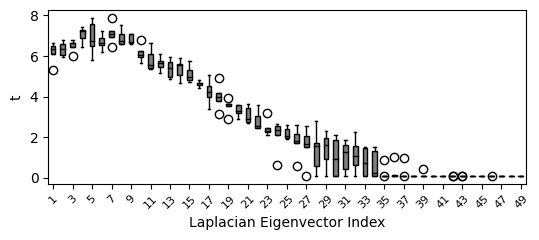

In [20]:
data_list = []

# Iterate over the replicates and K parameters
for replicate, k_dict in rep_dict.items():
    for laplacian_idx, bf_value in k_dict.items():
        data_list.append({'replicate': replicate, 'laplacian_idx': laplacian_idx, 'BF': bf_value})

df = pd.DataFrame(data_list)
df = df[df['laplacian_idx'] != 0]
df['laplacian_idx'] = df['laplacian_idx'].astype(int)
df = df.sort_values(['laplacian_idx', 'replicate'])
k_parameters = sorted(df['laplacian_idx'].unique())
data_to_plot = [df[df['laplacian_idx'] == k]['BF'].values for k in k_parameters]
positions = [val + 1 for val in range(len(k_parameters))]

fig, ax = plt.subplots(figsize=(5.5, 2.5))
bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True)
for box in bp['boxes']:
    box.set(facecolor='grey', edgecolor='black')

for whisker in bp['whiskers']:
    whisker.set(color='black')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='black')

ax.set_xlabel('Laplacian Eigenvector Index')
ax.set_ylabel('t')

xticks = positions[::2]  # Select every second position
xlabels = [str(k_parameters[i]) for i in range(0, len(k_parameters), 2)] 

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

ax.tick_params(axis='x', labelsize=8)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('../figures/figure_2/panel_g.pdf')
plt.show()


The below cells perform statistical tests (ANOVA and post-hoc tukey HSD) to determine staitsitcal significance of relationship between log-likelihood and the Laplacian eigenvector index (i.e. the controlled ruggedness element).

In [21]:
# Group log-likelihood values by the Laplacian eigenvector index.
groups = [df[df['laplacian_idx'] == k]['BF'].values for k in k_parameters]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df['BF'], df['laplacian_idx'])
post_hoc_res = comp.tukeyhsd()

ANOVA F-statistic: 132.9359828620236, p-value: 4.9780649128230074e-126


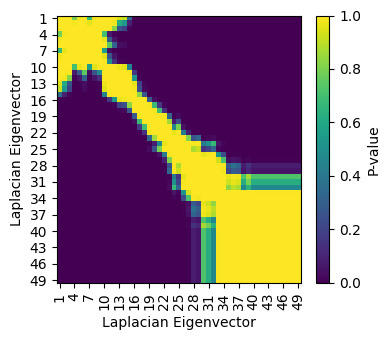

In [22]:
groups = list(post_hoc_res.groupsunique)
p_values = post_hoc_res.pvalues
post_hoc_res_df = pd.DataFrame(post_hoc_res.summary()).drop(0, axis=0)
matrix_size = len(groups)
p_matrix = np.ones((matrix_size, matrix_size))

group1 = [int(str(cell)) for cell in post_hoc_res_df[0]]
group2 = [int(str(cell)) for cell in post_hoc_res_df[1]]

for g1, g2, p in zip(group1, group2, p_values):
    idx1 = g1 - 1 
    idx2 = g2 - 1 
    p_matrix[idx1, idx2] = p
    p_matrix[idx2, idx1] = p  

fig, ax = plt.subplots(figsize=(4, 3.5))
im = ax.imshow(p_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im, label='P-value', ax=ax)
tick_indices = list(range(0, matrix_size, 3))
tick_labels = [groups[i] for i in tick_indices]

plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=90)
plt.yticks(ticks=tick_indices, labels=tick_labels)
plt.xlabel('Laplacian Eigenvector')
plt.ylabel('Laplacian Eigenvector')
plt.tight_layout()
plt.savefig('../si_figures/si_figure_1/panel_a.pdf')
plt.show()

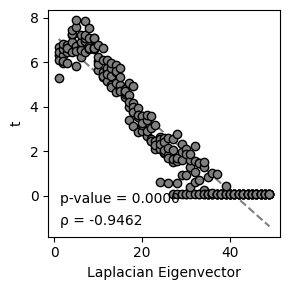

In [23]:
rho, p_value = spearmanr(df['laplacian_idx'], df['BF'])
slope, intercept = np.polyfit(df['laplacian_idx'], df['BF'], 1)
best_fit_line = np.array(df['laplacian_idx']) * slope + intercept

fig = plt.subplots(figsize=(3, 3))

plt.xlabel('Laplacian Eigenvector')
plt.ylabel('t')
plt.plot(df['laplacian_idx'], best_fit_line, color='grey', linestyle='--', zorder=1)

plt.scatter(df['laplacian_idx'], df['BF'], color='grey', linewidths=1, edgecolors='black')
plt.text(0.05, 0.05, f'ρ = {rho:.4f}', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.15, f'p-value = {p_value:.4f}', transform=plt.gca().transAxes, fontsize=10)
plt.tight_layout()
plt.savefig('../si_figures/si_figure_1/panel_b.pdf')
plt.show()

## NK-landscape simulations
NK landscapes are initialised with two parameters: `n`, the number of sites in the sequence and `k`, the number of sites that interact. Therefore, fitness landscapes where `k` is high (approaching `n`) resemble rugged / epistatic landscapes. 

The below cell simulates NK landscapes using `nk_landscape.generate_nk_landscape_amino_acids` at different values of `k`. The log-likelihood of each landscape is measured analogous to the Laplacian eigenvector simulated landscapes above. 

In [24]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(10):
    
    de_logprob_dict = {}
    h0_likelihood_dict = {}
    h1_likelihood_dict = {}
    de_dict = {}
    k_list = list(range(7))
    
    #Iterate through Laplacian eigenvectors.
    for k in k_list:

        Gnk = nk_landscape.generate_nk_landscape_amino_acids(N=8, K=k, amino_acids=['A', 'D'])
          
        #Compute energy.
        dir_energy = graph_ruggedness_de.compute_dirichlet_energy(G=Gnk)

        t_map, ci_lower, ci_upper, logpost_map, fiedler_val = fit_t_bayesian_laplace(G=Gnk, t_max=100, t_min=0.1)
        de_logprob_dict[k] = t_map
        
        #Save dirichlet energy to dictionary with eigenvector idx.
        de_dict[k] = dir_energy

    #Store -log(P) information to dictionary per replicate.
    rep_dict[_] = de_logprob_dict
    
    #Store Dirichlet energy to dictionary per replicate.
    rep_de_dict[_] = de_dict

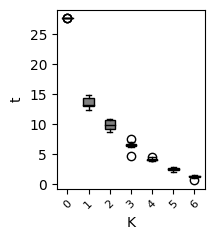

In [25]:

data_list = []

# Iterate over the replicates and K parameters
for replicate, k_dict in rep_dict.items():
    for k_param, bf_value in k_dict.items():
        data_list.append({'replicate': replicate, 'K_parameter': k_param, 'BF': bf_value})

df = pd.DataFrame(data_list)
df['K_parameter'] = df['K_parameter'].astype(int)
df = df.sort_values(['K_parameter', 'replicate'])
k_parameters = sorted(df['K_parameter'].unique())
data_to_plot = [df[df['K_parameter'] == k]['BF'].values for k in k_parameters]

fig, ax = plt.subplots(figsize=(2.25, 2.5))
bp = ax.boxplot(data_to_plot, positions=range(len(k_parameters)), patch_artist=True)

for box in bp['boxes']:
    box.set(facecolor='grey', edgecolor='black')

for whisker in bp['whiskers']:
    whisker.set(color='black')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='black')

ax.set_xlabel('K')
ax.set_ylabel('t')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis='x', labelsize=8)
ax.ticklabel_format(style='plain', axis='y')


plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('../figures/figure_2/panel_h.pdf')
plt.show()


The below cells perform ANOVA and post-hoc T-HSD test to find significant differences between the log likelihood and `k` parameters. 

In [26]:

# Group BF values by K_parameter
groups = [df[df['K_parameter'] == k]['BF'].values for k in k_parameters]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")

comp = mc.MultiComparison(df['BF'], df['K_parameter'])
post_hoc_res = comp.tukeyhsd()

ANOVA F-statistic: 2517.4815849835873, p-value: 5.157975975238867e-73


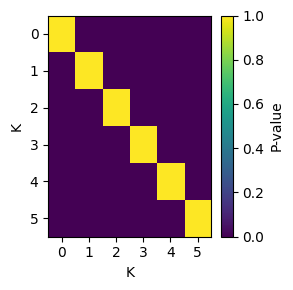

In [27]:
groups = [0, 1, 2, 3, 4, 5]
p_values = post_hoc_res.pvalues

matrix_size = len(groups)
p_matrix = np.ones((matrix_size, matrix_size))

group1 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]
group2 = [1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]

for g1, g2, p in zip(group1, group2, p_values):
    p_matrix[g1, g2] = p
    p_matrix[g2, g1] = p  # Ensure symmetry

    
fig = plt.subplots(figsize=(3, 3))

plt.imshow(p_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='P-value')
plt.xticks(ticks=range(matrix_size), labels=groups)
plt.yticks(ticks=range(matrix_size), labels=groups)

plt.xlabel('K')
plt.ylabel('K')
plt.tight_layout()
plt.savefig('../si_figures/si_figure_2/panel_a.pdf')
plt.show()

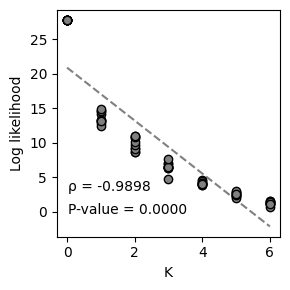

In [28]:
rho, p_value = spearmanr(df['K_parameter'], df['BF'])
slope, intercept = np.polyfit(df['K_parameter'], df['BF'], 1)
best_fit_line = np.array(df['K_parameter']) * slope + intercept

fig = plt.subplots(figsize=(3, 3))

plt.xlabel('K')
plt.ylabel('Log likelihood')
plt.plot(df['K_parameter'], best_fit_line, color='grey', linestyle='--', zorder=1)

# Scatter plot with color based on eigenvalue index
plt.scatter(df['K_parameter'], df['BF'], color='grey', linewidths=1, edgecolors='black')
plt.text(0.05, 0.2, f'ρ = {rho:.4f}', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.1, f'P-value = {p:.4f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('../si_figures/si_figure_2/panel_b.pdf')
plt.show()